In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
import random
import matplotlib.pyplot as plt
import keras
from keras.layers import LSTM, Dropout, Dense, Flatten, Input, LeakyReLU, BatchNormalization, Conv1D, MaxPooling1D
from keras.layers import TimeDistributed, RepeatVector
from keras.models import Sequential, Model, load_model
from keras.utils import plot_model
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import graphviz
import pydot

In [2]:
df = pd.read_csv("C:\\Users\\Kevin\\Desktop\\Data3001\datascience-cis-2022.csv")
df['time'] = pd.to_datetime(df['time'], unit='ns')

In [3]:
df_dev1 = df[df["device_mac"] == "bd:0d:8e:c5"]
df_dev1.set_index('time', inplace=True)

In [4]:
df_1d = df_dev1['2022-09-02 00:24:59.417':'2022-09-03 00:25:00.417']
df_1d2 = df_dev1['2022-09-09 00:24:59.417':'2022-09-10 00:25:00.620']
df_1h = df_dev1['2022-09-02 00:24:59.417':'2022-09-02 01:25:00.000']

In [5]:
dev1 = df_1d[['FromInternetTCPPort443IPurn:ietf:params:mud:controllerByteCount',              
              'FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
              'FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
              'FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount',
              'ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount',
              'ToInternetTCPPort443IPurn:ietf:params:mud:controllerByteCount',
              'ToInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
              'ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
              'ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount',
              'ToLocalUDPPort5353IP224.0.0.251/32ByteCount',
              'ToLocalUDPPort67IP255.255.255.255/32ByteCount']]

In [6]:
dev1_norm = (dev1-dev1.min())/(dev1.max()-dev1.min())
dev1_norm = dev1_norm.fillna(0)

In [7]:
dev1_clean = dev1_norm.loc[:, (dev1_norm != 0).any(axis=0)]

In [8]:
dev1_clean.head(10)

,FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount,ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount,ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount,ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount,ToLocalUDPPort67IP255.255.255.255/32ByteCount
time,,,,,
2022-09-02 00:24:59.417,0.0,0.333333,0.138546,0.147963,0.0
2022-09-02 00:25:59.386,0.0,0.333333,0.173852,0.119089,0.0
2022-09-02 00:26:59.365,0.0,0.333333,0.164046,0.136821,0.0
2022-09-02 00:27:59.422,0.0,0.333333,0.134518,0.137797,0.0
2022-09-02 00:28:59.461,0.5,0.333333,0.138213,0.150187,0.5
2022-09-02 00:29:59.399,0.5,0.333333,0.125291,0.122232,0.5
2022-09-02 00:30:59.533,0.5,0.333333,0.142872,0.121132,0.5
2022-09-02 00:31:59.428,0.0,0.333333,0.133437,0.138675,0.0
2022-09-02 00:32:59.459,0.0,0.333333,0.167350,0.135522,0.0


Text(0, 0.5, 'byte count')

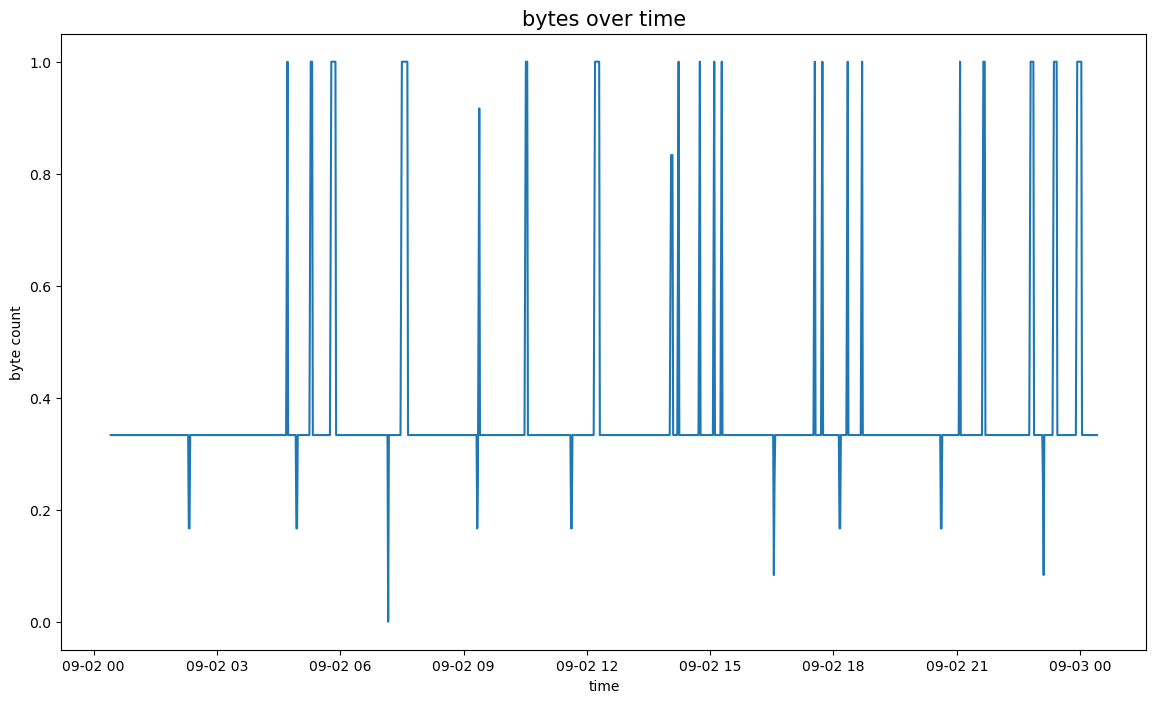

In [13]:
plt.figure(figsize=(14,8))
plt.title("bytes over time", fontdict={"fontsize": 15})

ax = sns.lineplot(x='time', y='ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount', data=dev1_clean)
    
plt.ylabel('byte count')

In [9]:
train_size = int(0.8 * len(dev1_clean))
test_size = len(dev1_clean) - train_size
train, test = dev1_clean.iloc[0:train_size], dev1_clean.iloc[train_size:len(dev1_clean)]

In [10]:
def batch(X, y, time_steps=1):
    series_X, series_Y = [], []
    for i in range(len(X) - time_steps):
        new = X.iloc[i: (i + time_steps)].to_numpy()
        series_X.append(new)
        series_Y.append(y.iloc[i + time_steps])
    return np.array(series_X), np.array(series_Y)

In [11]:
TIME = 20

X_train_2, y_train_2 = batch(train, train['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)
X_test_2, y_test_2 = batch(test, test['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)

In [12]:
def split(X, look_back=1, forecast=1):
    series_X, series_y = [], []
    for i in range(len(X)):
        if (i + look_back + forecast) > len(X):
            break
        new = X.iloc[i: (i + look_back)]
        new_2 = X.iloc[(i + look_back): (i + look_back + forecast)]
        series_X.append(new)
        series_y.append(new_2)
    return np.array(series_X), np.array(series_y)

In [13]:
train_new, test_new = train.reset_index(drop=True), test.reset_index(drop=True)

In [14]:
X_train, y_train = split(train_new, look_back = 20, forecast = 10)
X_test, y_test = split(test_new, look_back = 20, forecast = 10)

In [15]:
output_length = len(dev1_clean.columns)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(RepeatVector(10))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(50, activation='sigmoid')))
model.add(TimeDistributed(Dense(output_length)))
model.compile(optimizer='adam', loss='mse')

In [16]:
history = model.fit(X_train, y_train,
                   epochs = 30,
                   batch_size=10,
                   validation_split=0.1,
                   shuffle=False)

Epoch 1/30
96/96 [==============================] - 3s 11ms/step - loss: 0.0538 - val_loss: 0.0286
Epoch 2/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0272 - val_loss: 0.0254
Epoch 3/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0234 - val_loss: 0.0225
Epoch 4/30
96/96 [==============================] - 1s 7ms/step - loss: 0.0204 - val_loss: 0.0186
Epoch 5/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0184 - val_loss: 0.0171
Epoch 6/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0176 - val_loss: 0.0170
Epoch 7/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 8/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0168 - val_loss: 0.0167
Epoch 9/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0164 - val_loss: 0.0165
Epoch 10/30
96/96 [==============================] - 1s 6ms/step - loss: 0.0161 - val_loss: 0.0163
Epoch 11/30
96/96 

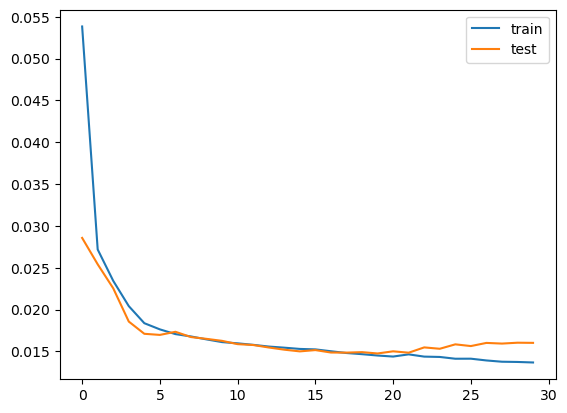

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
y_pred = model.predict(X_test)

8/8 [==============================] - 0s 3ms/step


In [19]:
y_pred_new = y_pred.transpose(2,0,1).reshape(output_length,-1).T

In [20]:
y_test_new = y_test.transpose(2,0,1).reshape(output_length,-1).T

In [21]:
df_pred = pd.DataFrame(y_pred_new)
df_pred.columns = ['FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount', 
                  'ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount',
                  'ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
                  'ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount',
                  'ToLocalUDPPort67IP255.255.255.255/32ByteCount']

In [22]:
df_test = pd.DataFrame(y_test_new)
df_test.columns = ['FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount', 
                  'ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount',
                  'ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
                  'ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount',
                  'ToLocalUDPPort67IP255.255.255.255/32ByteCount']

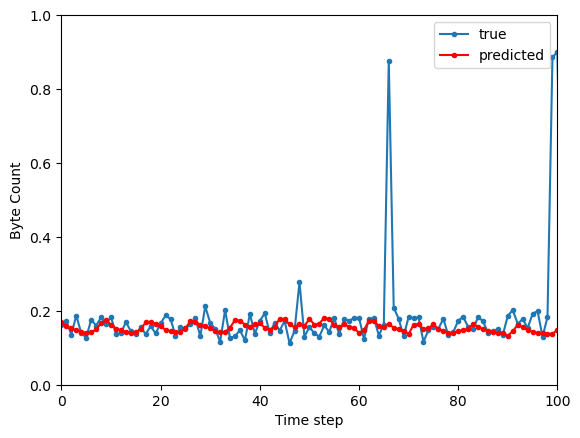

In [53]:
plt.xlim(0,100)
plt.ylim(0,1.0)
plt.plot(y_test_2, marker='.', label='true')
plt.plot(df_pred['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], 'r', marker='.', label='predicted')
plt.ylabel('Byte Count')
plt.xlabel('Time step')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

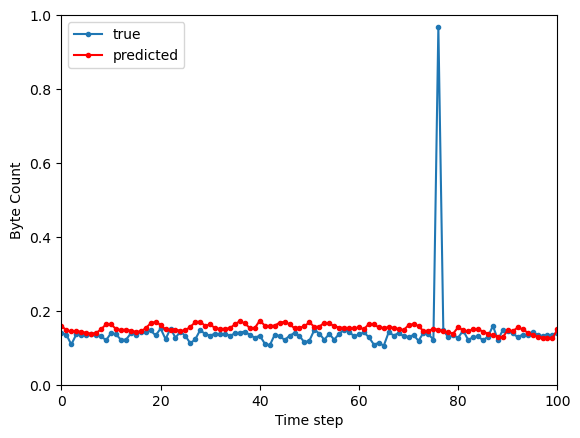

In [179]:
plt.xlim(0,100)
plt.ylim(0,1.0)
plt.plot(y_test, marker='.', label='true')
plt.plot(df_pred['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount'], 'r', marker='.', label='predicted')
plt.ylabel('Byte Count')
plt.xlabel('Time step')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [180]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

distance_80, path = fastdtw(y_test_2, df_pred['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], dist=euclidean)
distance_1024, path = fastdtw(y_test, df_pred['ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount'], dist=euclidean)

In [182]:
distance_80, distance_1024

(44.625688575846645, 44.81094044001197)

In [1]:
# CNN-encode-decode-LSTM performed worse than LSTM